# California Housing Price Prediction

In [2]:
import os
import tarfile
import requests
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100%; }</style>"))
np.set_printoptions(precision=3, suppress=True)

In [3]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = Path("datasets/housing")

def fetch_housing_data(dwld_path=DOWNLOAD_ROOT, housing_path=HOUSING_PATH):
    housing_path.mkdir(parents=True, exist_ok=True)
    tgz_path = housing_path / "housing.tgz"
    resp = requests.get(dwld_path + str(tgz_path))
    with open(tgz_path, "wb") as f:
        f.write(resp.content)        
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [4]:
fetch_housing_data()

In [5]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = housing_path / "housing.csv"
    return pd.read_csv(csv_path)

In [6]:
## Inspect column types and count for missing values 

housing = load_housing_data()
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [7]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [8]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10fd18350>,
      dtype=object)

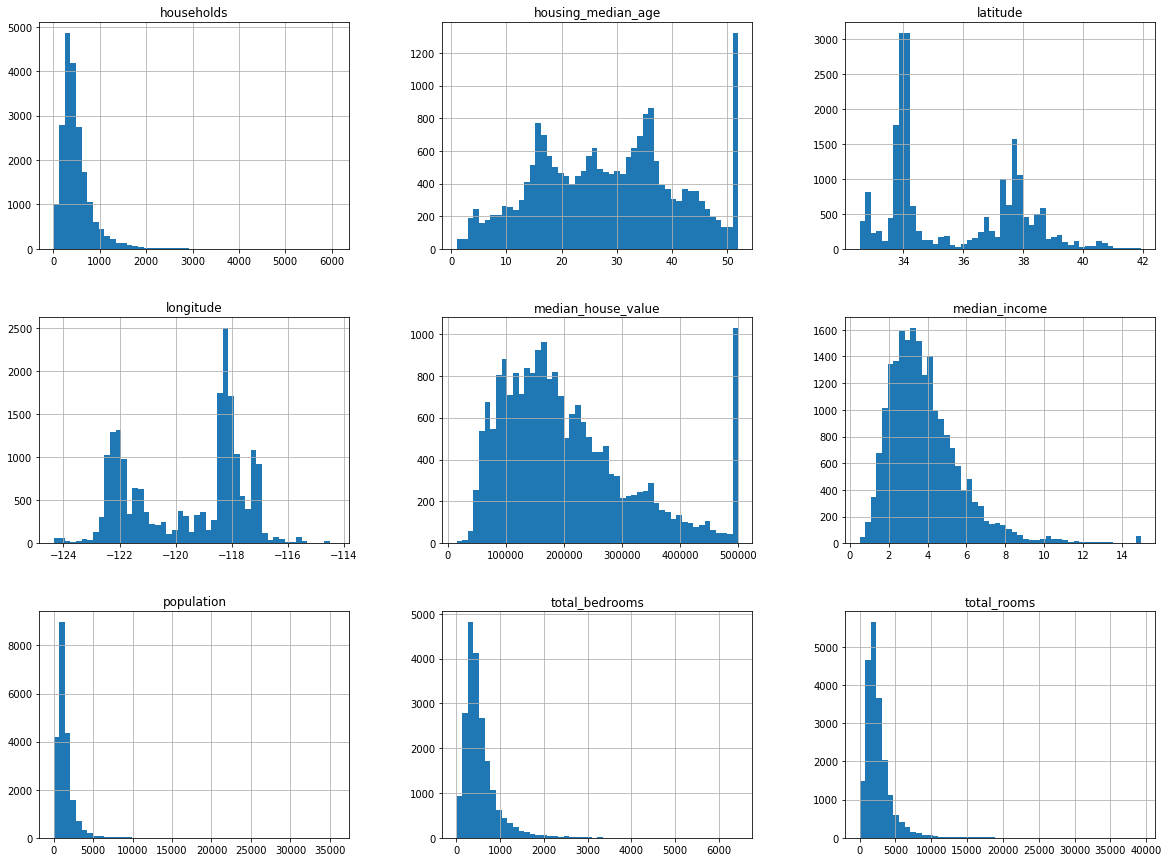

In [9]:
## Some columns are capped to a maximum value for e.g housing_median_age and median_house_value
housing.hist(bins=50, figsize=(20, 15))

### Inspect Categorical Data

In [10]:
housing["ocean_proximity"].unique()

array(['NEAR BAY', '<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'ISLAND'],
      dtype=object)

In [11]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

### Visualizing Geographic Data

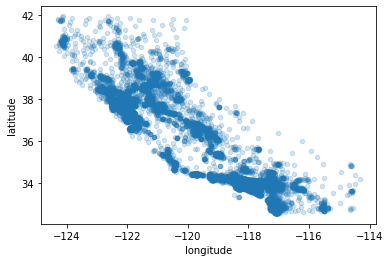

In [12]:
## Inspect longitude and latitude

housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.2)

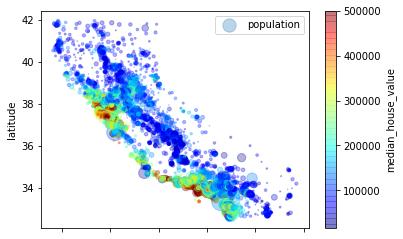

In [13]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.3, 
             s=housing["population"]/100,
             label="population",
             c="median_house_value",
             cmap=plt.get_cmap("jet"),
             colorbar=True)

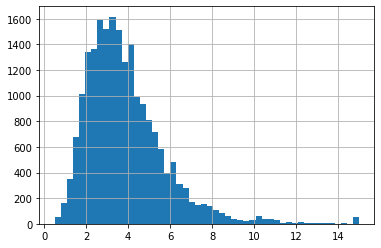

In [14]:
## Higher median income likely results in higher median house price

housing["median_income"].hist(bins=50)

In [15]:
# housing["cat_income"] = np.ceil(housing["median_income"] / 1.5)
# housing["cat_income"].where(housing["cat_income"] < 5, 5.0, inplace=True)

housing["cat_income"] = pd.cut(housing["median_income"],
                               bins=[0, 1.5, 3, 4.5, 6, np.inf], 
                               labels=[1, 2, 3, 4, 5])

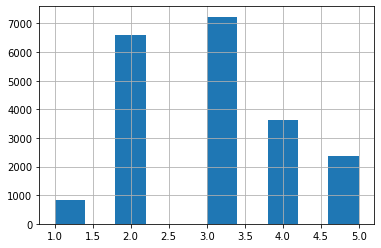

In [16]:
housing["cat_income"].hist()

In [17]:
housing["cat_income"].value_counts() / len(housing["cat_income"])

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: cat_income, dtype: float64

In [18]:
# from sklearn.model_selection import train_test_split
# housing_train, housing_test = train_test_split(housing, test_size=0.2)

## Split training and test sets according to distribution of income 
from sklearn.model_selection import StratifiedShuffleSplit

strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
for train_idx, test_idx in strat_split.split(housing, housing["cat_income"]):
    housing_train = housing.loc[train_idx]
    housing_test = housing.loc[test_idx]

In [19]:
len(housing_train), len(housing_test), len(housing_train) + len(housing_test) 

(16512, 4128, 20640)

In [20]:
housing_train["cat_income"].value_counts() / len(housing_train["cat_income"])

3    0.350594
2    0.318859
4    0.176296
5    0.114402
1    0.039850
Name: cat_income, dtype: float64

In [21]:
housing_test["cat_income"].value_counts() / len(housing_test["cat_income"])

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: cat_income, dtype: float64

In [22]:
for dataset in (housing_train, housing_test):
    dataset.drop(["cat_income"], axis=1, inplace=True)

In [23]:
## Looking for Correlations 

corr_matrix = housing_train.corr()
corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924868,-0.112561,0.043151,0.067330,0.099235,0.052913,-0.009870,-0.046672
latitude,-0.924868,1.000000,0.014335,-0.035928,-0.065222,-0.108451,-0.068837,-0.085065,-0.144167
housing_median_age,-0.112561,0.014335,1.000000,-0.356241,-0.316678,-0.299267,-0.298795,-0.117015,0.109907
total_rooms,0.043151,-0.035928,-0.356241,1.000000,0.930520,0.867745,0.918922,0.203815,0.135308
total_bedrooms,0.067330,-0.065222,-0.316678,0.930520,1.000000,0.888634,0.979891,-0.002620,0.050856
population,0.099235,-0.108451,-0.299267,0.867745,0.888634,1.000000,0.917546,0.009717,-0.023776
households,0.052913,-0.068837,-0.298795,0.918922,0.979891,0.917546,1.000000,0.018328,0.067123
median_income,-0.009870,-0.085065,-0.117015,0.203815,-0.002620,0.009717,0.018328,1.000000,0.686329
median_house_value,-0.046672,-0.144167,0.109907,0.135308,0.050856,-0.023776,0.067123,0.686329,1.000000


In [24]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.686329
total_rooms           0.135308
housing_median_age    0.109907
households            0.067123
total_bedrooms        0.050856
population           -0.023776
longitude            -0.046672
latitude             -0.144167
Name: median_house_value, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10e9b5710>,
      dtype=object)

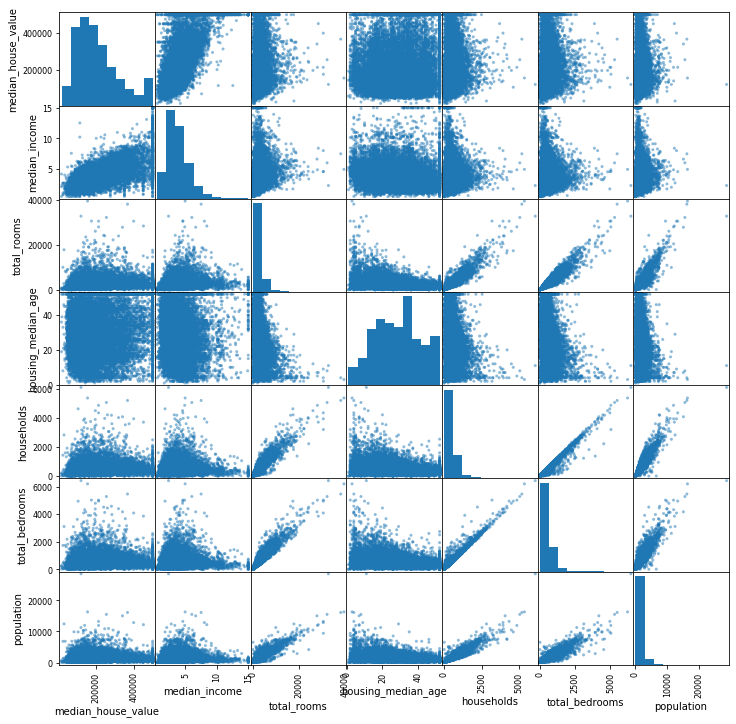

In [25]:
from pandas.plotting import scatter_matrix

columns = ["median_house_value", "median_income", "total_rooms", "housing_median_age", "households", 
           "total_bedrooms", "population"]
scatter_matrix(housing_train[columns], figsize=(12,12))

## Feature Engineering
### Experimenting with Attribute Combinations

In [26]:
housing_train["rooms_per_household"] = housing_train["total_rooms"] / housing_train["households"]
housing_train["bedrooms_per_room"] = housing_train["total_bedrooms"] / housing_train["total_rooms"]
housing_train["population_per_household"] = housing_train["population"] / housing_train["households"]

In [27]:
corr_matrix = housing_train.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.686329
rooms_per_household         0.167878
total_rooms                 0.135308
housing_median_age          0.109907
households                  0.067123
total_bedrooms              0.050856
population                 -0.023776
population_per_household   -0.034668
longitude                  -0.046672
latitude                   -0.144167
bedrooms_per_room          -0.255034
Name: median_house_value, dtype: float64

In [28]:
## Top 5 columns

np.array(corr_matrix["median_house_value"].sort_values(ascending=False).index)[:5]

array(['median_house_value', 'median_income', 'rooms_per_household',
       'total_rooms', 'housing_median_age'], dtype=object)

In [29]:
housing_labels = housing_train["median_house_value"].copy()
housing_train.drop(["median_house_value", "rooms_per_household", "bedrooms_per_room", "population_per_household"], axis=1, inplace=True)

In [30]:
housing_train.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
5898,-118.30,34.17,16.0,1353.0,398.0,1211.0,357.0,3.1551,<1H OCEAN
7012,-118.07,33.96,30.0,928.0,230.0,913.0,214.0,2.6991,<1H OCEAN
19941,-119.46,36.25,32.0,1702.0,348.0,1016.0,350.0,2.5000,INLAND
3152,-118.46,35.13,19.0,3109.0,640.0,1457.0,620.0,2.6417,INLAND
18934,-122.18,38.29,18.0,1953.0,265.0,658.0,270.0,8.0113,NEAR BAY


In [31]:
housing_labels.head()

5898     205000.0
7012     147100.0
19941     73600.0
3152      94900.0
18934    393000.0
Name: median_house_value, dtype: float64

### Data Cleaning

In [32]:
# Fill in missing data from "Total Bedrooms" column with median value

from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

housing_numeric = housing_train.drop("ocean_proximity", axis=1)
imputer.fit(housing_numeric)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

In [33]:
imputer.statistics_, housing_numeric.median().values

(array([-118.5  ,   34.26 ,   29.   , 2129.   ,  436.   , 1169.   ,
         410.   ,    3.534]),
 array([-118.5  ,   34.26 ,   29.   , 2129.   ,  436.   , 1169.   ,
         410.   ,    3.534]))

In [34]:
X = imputer.transform(housing_numeric)
X[:5]

array([[-118.3  ,   34.17 ,   16.   , 1353.   ,  398.   , 1211.   ,
         357.   ,    3.155],
       [-118.07 ,   33.96 ,   30.   ,  928.   ,  230.   ,  913.   ,
         214.   ,    2.699],
       [-119.46 ,   36.25 ,   32.   , 1702.   ,  348.   , 1016.   ,
         350.   ,    2.5  ],
       [-118.46 ,   35.13 ,   19.   , 3109.   ,  640.   , 1457.   ,
         620.   ,    2.642],
       [-122.18 ,   38.29 ,   18.   , 1953.   ,  265.   ,  658.   ,
         270.   ,    8.011]])

In [35]:
housing_tr = pd.DataFrame(X, columns=housing_numeric.columns)
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-118.30,34.17,16.0,1353.0,398.0,1211.0,357.0,3.1551
1,-118.07,33.96,30.0,928.0,230.0,913.0,214.0,2.6991
2,-119.46,36.25,32.0,1702.0,348.0,1016.0,350.0,2.5000
3,-118.46,35.13,19.0,3109.0,640.0,1457.0,620.0,2.6417
4,-122.18,38.29,18.0,1953.0,265.0,658.0,270.0,8.0113


In [36]:
housing_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16512 entries, 0 to 16511
Data columns (total 8 columns):
longitude             16512 non-null float64
latitude              16512 non-null float64
housing_median_age    16512 non-null float64
total_rooms           16512 non-null float64
total_bedrooms        16512 non-null float64
population            16512 non-null float64
households            16512 non-null float64
median_income         16512 non-null float64
dtypes: float64(8)
memory usage: 1.0 MB


### Handing Text and Categorical Data

In [37]:
from sklearn.preprocessing import OrdinalEncoder 

ordinal_encoder = OrdinalEncoder()
housing_cat = housing_train[["ocean_proximity"]]
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

In [38]:
housing_train[["ocean_proximity"]][:5]

,ocean_proximity
5898,<1H OCEAN
7012,<1H OCEAN
19941,INLAND
3152,INLAND
18934,NEAR BAY


In [39]:
housing_cat_encoded[:5]

array([[0.],
       [0.],
       [1.],
       [1.],
       [3.]])

In [40]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [41]:
from sklearn.preprocessing import OneHotEncoder  # defaults to sparse Scipy matrix

oh_encoder = OneHotEncoder()
housing_cat_1hot = oh_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [42]:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [43]:
oh_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [44]:
from sklearn.preprocessing import LabelBinarizer # defaults to dense Numpy Array

lb_encoder = LabelBinarizer()
housing_cat_1hot = lb_encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       ...,
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0]])

In [45]:
lb_encoder = LabelBinarizer(sparse_output=True)
housing_cat_1hot = lb_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.int64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [46]:
# Or use Pandas get_dummies()

pd.get_dummies(housing_cat)[:5]

,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
5898,1,0,0,0,0
7012,1,0,0,0,0
19941,0,1,0,0,0
3152,0,1,0,0,0
18934,0,0,0,1,0


### Custom Transformer

In [47]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_col, bedrooms_col, populations_col, household_col = 3, 4, 5, 6

class CombinedAttributeAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_col] / X[:, household_col] 
        population_per_household = X[:, populations_col] / X[:, household_col]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_col] / X[:, rooms_col]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [48]:
housing_train.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
5898,-118.30,34.17,16.0,1353.0,398.0,1211.0,357.0,3.1551,<1H OCEAN
7012,-118.07,33.96,30.0,928.0,230.0,913.0,214.0,2.6991,<1H OCEAN
19941,-119.46,36.25,32.0,1702.0,348.0,1016.0,350.0,2.5000,INLAND
3152,-118.46,35.13,19.0,3109.0,640.0,1457.0,620.0,2.6417,INLAND
18934,-122.18,38.29,18.0,1953.0,265.0,658.0,270.0,8.0113,NEAR BAY


In [49]:
## Added the 2 extra columns 

attr_adder = CombinedAttributeAdder(add_bedrooms_per_room=False)
housing_extra_attrib = attr_adder.fit_transform(housing_train.values)
print(housing_train.shape, housing_extra_attrib.shape)

(16512, 9) (16512, 11)


## Preprocessing: Feature Scaling
### Both these columns has wide fluctuations between min and max values

In [50]:
housing_train[["total_rooms", "median_income"]].describe()

,total_rooms,median_income
count,16512.000000,16512.000000
mean,2639.180596,3.868058
std,2181.373266,1.892435
min,2.000000,0.499900
25%,1453.000000,2.564850
50%,2129.000000,3.534300
75%,3155.000000,4.740575
max,39320.000000,15.000100


### Transformation Pipelines

In [51]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("attr_adder", CombinedAttributeAdder()),
    ("std_scaler", StandardScaler())
])

housing_numeric_tr = numeric_pipeline.fit_transform(housing_numeric)

In [52]:
housing_numeric_tr

array([[ 0.632, -0.684, -1.002, ..., -0.76 ,  0.062,  1.211],
       [ 0.747, -0.783,  0.107, ..., -0.507,  0.204,  0.514],
       [ 0.054,  0.29 ,  0.265, ..., -0.262, -0.017, -0.138],
       ...,
       [ 0.677, -0.689, -0.289, ...,  0.167, -0.058, -0.649],
       [-1.182,  0.983, -0.527, ...,  0.651, -0.006, -1.002],
       [-1.426,  1.011,  1.85 , ..., -0.719, -0.263,  1.314]])

In [53]:
# from sklearn.base import BaseEstimator, TransformerMixin

# class DataFrameSelector(BaseEstimator, TransformerMixin):
#     def __init__(self, attribute_names):
#         self.attribute_names = attribute_names
#     def fit(self, X, y=None):
#         return self
#     def transform(self, X, y=None):
#         return X[self.attribute_names].values

In [54]:
# from sklearn.pipeline import FeatureUnion
from sklearn.compose import ColumnTransformer

numeric_attr = list(housing_numeric.columns)
cat_attr = ["ocean_proximity"]

numeric_pipeline = Pipeline([
#     ("selector", DataFrameSelector(numeric_attr)),
    ("imputer", SimpleImputer(strategy="median")),
    ("attr_adder", CombinedAttributeAdder()),
    ("std_scaler", StandardScaler())    
])

cat_pipeline = Pipeline([
#     ("selector", DataFrameSelector(cat_attr)),
    ("oh_encoder", OneHotEncoder(sparse=False))
])

# full_pipeline = FeatureUnion(transformer_list=[
#     ("numeric_pipeline", numeric_pipeline),
#     ("cat_pipeline", cat_pipeline)
# ])

full_pipeline = ColumnTransformer([
    ("numeric_pipeline", numeric_pipeline, numeric_attr),
    ("cat_pipeline", cat_pipeline, cat_attr)
])

In [55]:
housing_prepared = full_pipeline.fit_transform(housing_train)
housing_prepared[:5]

array([[ 0.632, -0.684, -1.002, -0.59 , -0.332, -0.192, -0.374, -0.377,
        -0.76 ,  0.062,  1.211,  1.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.747, -0.783,  0.107, -0.784, -0.735, -0.461, -0.751, -0.618,
        -0.507,  0.204,  0.514,  1.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.054,  0.29 ,  0.265, -0.43 , -0.452, -0.368, -0.393, -0.723,
        -0.262, -0.017, -0.138,  0.   ,  1.   ,  0.   ,  0.   ,  0.   ],
       [ 0.552, -0.235, -0.764,  0.215,  0.249,  0.031,  0.318, -0.648,
        -0.192, -0.107, -0.117,  0.   ,  1.   ,  0.   ,  0.   ,  0.   ],
       [-1.302,  1.245, -0.844, -0.315, -0.651, -0.692, -0.603,  2.189,
         0.839, -0.093, -1.172,  0.   ,  0.   ,  0.   ,  1.   ,  0.   ]])

In [56]:
housing_prepared.shape

(16512, 16)

In [57]:
## Training and Evaluating on Training Set

from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [58]:
from sklearn.metrics import mean_squared_error

housing_prediction = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_prediction, housing_labels)
lin_rmse = np.sqrt(lin_mse)
print(lin_rmse)

68168.52693078159


In [59]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

housing_prediction = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_prediction, housing_labels)
tree_rmse = np.sqrt(tree_mse)
print(tree_rmse)
# RMSE = 0 because model badly overfitting the data without cross validation

0.0


In [60]:
def display_rmse_scores(model, scores):
    rsme_scores = np.sqrt(-scores)
    
    print("Model:\t", type(model).__name__)
    print("Scores:\t", rsme_scores)
    print(f"Mean:\t {rsme_scores.mean():.3f}")
    print(f"Std Dev: {rsme_scores.std():.3f}")

In [61]:
from sklearn.model_selection import cross_val_score

tree_scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
display_rmse_scores(tree_reg, tree_scores)

Model:	 DecisionTreeRegressor
Scores:	 [70494.767 73127.044 72042.581 77003.972 68789.721 69153.585 69249.089
 68603.075 73694.918 68266.098]
Mean:	 71042.485
Std Dev: 2715.484


In [62]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
display_rmse_scores(lin_reg, lin_scores)

Model:	 LinearRegression
Scores:	 [ 69580.41   73150.521 119750.454  70574.793  66339.445  66244.163
  65999.781  69607.048  68217.043  64456.934]
Mean:	 73392.059
Std Dev: 15646.233


In [63]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

housing_prediction = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_prediction, housing_labels)
forest_rmse = np.sqrt(forest_mse)
print(forest_rmse)

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
display_rmse_scores(forest_reg, forest_scores)

18658.310296520525
Model:	 RandomForestRegressor
Scores:	 [51287.248 52934.602 52315.421 54177.474 49279.08  47439.047 49523.224
 50691.743 50153.287 47375.039]
Mean:	 50517.617
Std Dev: 2123.677


## Hyperparameter Tuning
### Grid Search

In [64]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {"n_estimators": [3, 10, 30, 50, 60, 70], "max_features": [2, 3, 4, 5]},
    {"bootstrap": [False], "n_estimators": [3, 8, 17, 50, 65], "max_features": [2, 3, 4, 5]}
]

grid_search = GridSearchCV(forest_reg, param_grid=param_grid, cv=5, scoring="neg_mean_squared_error", verbose=2, n_jobs=-1)
grid_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 44 candidates, totalling 220 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   54.3s
[Parallel(n_jobs=-1)]: Done 220 out of 220 | elapsed:  1.6min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [65]:
grid_search.best_params_

{'bootstrap': False, 'max_features': 5, 'n_estimators': 65}

In [66]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=5, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=65, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [67]:
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results[:5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.161925,0.006858,0.009754,0.002691,2,3,NaN,"{'max_features': 2, 'n_estimators': 3}",-4.213921e+09,-4.536393e+09,-3.786049e+09,-4.089389e+09,-4.142678e+09,-4.153686e+09,2.406261e+08,44
1,0.551524,0.011984,0.024165,0.004394,2,10,NaN,"{'max_features': 2, 'n_estimators': 10}",-3.182563e+09,-3.277498e+09,-2.898435e+09,-3.092437e+09,-2.864782e+09,-3.063143e+09,1.597143e+08,36
2,1.622392,0.009460,0.069658,0.004788,2,30,NaN,"{'max_features': 2, 'n_estimators': 30}",-2.858309e+09,-3.095229e+09,-2.653704e+09,-2.779862e+09,-2.602283e+09,-2.797877e+09,1.740332e+08,32
3,2.721231,0.020754,0.094544,0.003286,2,50,NaN,"{'max_features': 2, 'n_estimators': 50}",-2.811260e+09,-3.002286e+09,-2.557571e+09,-2.695903e+09,-2.637620e+09,-2.740928e+09,1.546440e+08,28
4,3.283150,0.036429,0.128579,0.016245,2,60,NaN,"{'max_features': 2, 'n_estimators': 60}",-2.756202e+09,-2.969063e+09,-2.592987e+09,-2.660406e+09,-2.598266e+09,-2.715385e+09,1.398138e+08,27


In [68]:
for mean_test_score, params in zip(cv_results["mean_test_score"], cv_results["params"]):
    print(np.sqrt(-mean_test_score), params)

64449.094499972896 {'max_features': 2, 'n_estimators': 3}
55345.667130552174 {'max_features': 2, 'n_estimators': 10}
52894.964271711295 {'max_features': 2, 'n_estimators': 30}
52353.87043472597 {'max_features': 2, 'n_estimators': 50}
52109.35472444617 {'max_features': 2, 'n_estimators': 60}
51985.34469829689 {'max_features': 2, 'n_estimators': 70}
62402.53640533636 {'max_features': 3, 'n_estimators': 3}
53655.742760611414 {'max_features': 3, 'n_estimators': 10}
51507.77593946639 {'max_features': 3, 'n_estimators': 30}
50778.15120196276 {'max_features': 3, 'n_estimators': 50}
50523.52643931502 {'max_features': 3, 'n_estimators': 60}
50611.536369812464 {'max_features': 3, 'n_estimators': 70}
59395.480761735584 {'max_features': 4, 'n_estimators': 3}
52767.242877412195 {'max_features': 4, 'n_estimators': 10}
50611.6764392031 {'max_features': 4, 'n_estimators': 30}
50137.46646637712 {'max_features': 4, 'n_estimators': 50}
49886.19116520737 {'max_features': 4, 'n_estimators': 60}
49937.60969

### Randomized Search 

In [69]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
# randint probability mass function: f(k) = 1 / (high - low)

param_dist = {
    "n_estimators": randint(low=1, high=100),
    "max_features": randint(low=1, high=8)
}

rand_search = RandomizedSearchCV(forest_reg, param_distributions=param_dist, cv=5, n_iter=10, scoring="neg_mean_squared_error", verbose=2, n_jobs=-1)
rand_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   36.1s finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [70]:
cv_results = pd.DataFrame(rand_search.cv_results_)

for mean_test_score, params in zip(cv_results["mean_test_score"], cv_results["params"]):
    print(np.sqrt(-mean_test_score), params)

49972.21374790154 {'max_features': 4, 'n_estimators': 72}
50045.540299766835 {'max_features': 6, 'n_estimators': 40}
50771.37952404347 {'max_features': 4, 'n_estimators': 23}
49627.6775762466 {'max_features': 5, 'n_estimators': 62}
50243.003743332425 {'max_features': 4, 'n_estimators': 35}
49742.63990361672 {'max_features': 5, 'n_estimators': 63}
52072.51030486367 {'max_features': 3, 'n_estimators': 22}
49415.55188339372 {'max_features': 6, 'n_estimators': 85}
49735.481856891216 {'max_features': 7, 'n_estimators': 58}
50584.69369532764 {'max_features': 3, 'n_estimators': 62}


In [71]:
rand_search.best_params_

{'max_features': 6, 'n_estimators': 85}

In [72]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([0.086, 0.082, 0.04 , 0.019, 0.017, 0.018, 0.017, 0.293, 0.066,
       0.106, 0.084, 0.017, 0.143, 0.   , 0.005, 0.008])

In [73]:
## extra attributes 
extra_attr = ["rooms_per_household", "bedrooms_per_room", "population_per_household"]
cat_attr = list(lb_encoder.classes_)
col_names = list(housing_numeric.columns) + extra_attr + cat_attr
col_names

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'rooms_per_household',
 'bedrooms_per_room',
 'population_per_household',
 '<1H OCEAN',
 'INLAND',
 'ISLAND',
 'NEAR BAY',
 'NEAR OCEAN']

In [74]:
sorted(zip(feature_importances, col_names), reverse=True)

[(0.2934529210763414, 'median_income'),
 (0.1428005336742877, 'INLAND'),
 (0.10552475928534533, 'bedrooms_per_room'),
 (0.0861380866189822, 'longitude'),
 (0.08386631287392164, 'population_per_household'),
 (0.08206359350654996, 'latitude'),
 (0.06555319852520908, 'rooms_per_household'),
 (0.03979559574363543, 'housing_median_age'),
 (0.018591545640443415, 'total_rooms'),
 (0.018306780704307805, 'population'),
 (0.017036271850970182, 'total_bedrooms'),
 (0.016791223070730037, '<1H OCEAN'),
 (0.016668846169499034, 'households'),
 (0.007854284806916316, 'NEAR OCEAN'),
 (0.0053424908951469645, 'NEAR BAY'),
 (0.0002135555577134948, 'ISLAND')]

In [75]:
from sklearn.svm import SVR

svr_reg = SVR()
svr_reg.fit(housing_prepared, housing_labels)
housing_prediction = svr_reg.predict(housing_prepared)

svr_mse = mean_squared_error(housing_prediction, housing_labels)
svr_rmse = np.sqrt(svr_mse)
print(svr_rmse)

svr_scores = cross_val_score(svr_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
display_rmse_scores(svr_reg, svr_scores)

118470.24515084267
Model:	 SVR
Scores:	 [118261.106 119412.878 117589.304 119363.553 117066.704 118548.113
 116295.765 119015.091 120568.464 118876.647]
Mean:	 118499.762
Std Dev: 1186.024


### Different Distributions for GridSearch and RandomizedSearch 

(array([179., 200., 208., 214., 201., 207., 179., 204., 207., 206., 229.,
        202., 181., 203., 196., 200., 206., 196., 198., 209., 197., 178.,
        203., 200., 181., 192., 198., 207., 205., 213., 188., 206., 183.,
        209., 208., 192., 195., 207., 203., 210., 172., 204., 212., 202.,
        197., 189., 199., 210., 218., 197.]),
 array([2.303, 2.349, 2.395, 2.441, 2.487, 2.533, 2.579, 2.625, 2.671,
        2.717, 2.763, 2.809, 2.855, 2.901, 2.947, 2.993, 3.039, 3.085,
        3.132, 3.178, 3.224, 3.27 , 3.316, 3.362, 3.408, 3.454, 3.5  ,
        3.546, 3.592, 3.638, 3.684, 3.73 , 3.776, 3.822, 3.868, 3.914,
        3.96 , 4.006, 4.053, 4.099, 4.145, 4.191, 4.237, 4.283, 4.329,
        4.375, 4.421, 4.467, 4.513, 4.559, 4.605]),
 <a list of 50 Patch objects>)

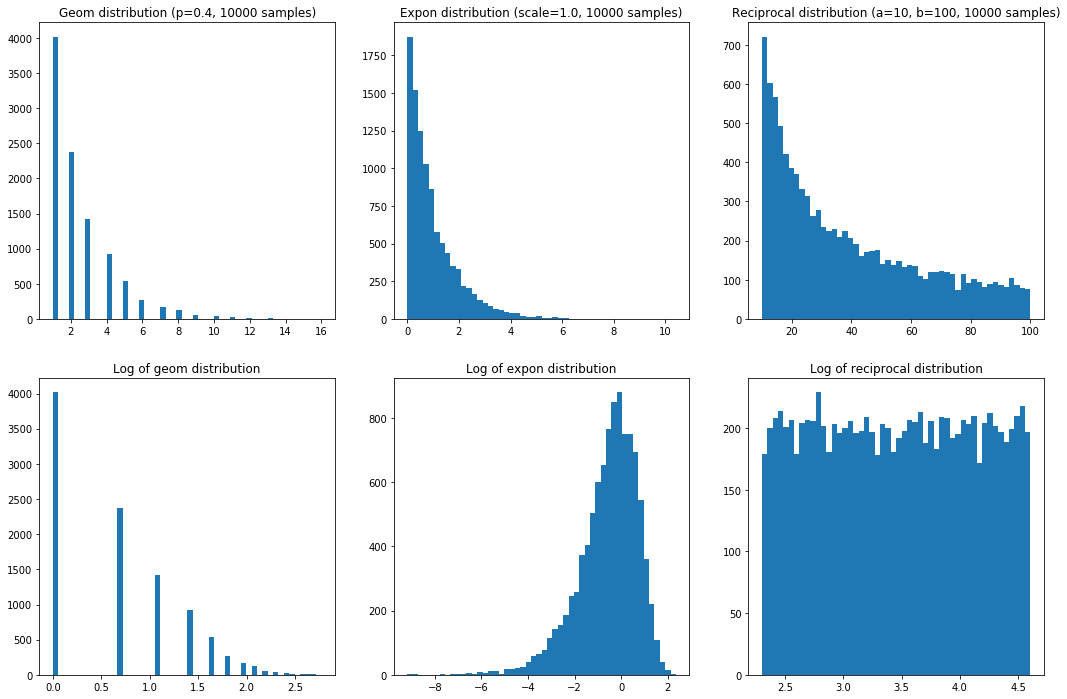

In [76]:
from scipy.stats import geom, expon, reciprocal

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))

# geometric: f(k) = (1-p)^(k-1) * p for k ≥ 1
geom_dist = geom(p=0.4).rvs(size=10000)
axes[0, 0].set_title("Geom distribution (p=0.4, 10000 samples)")
axes[0, 0].hist(geom_dist, bins=50)
axes[1, 0].set_title("Log of geom distribution")
axes[1, 0].hist(np.log(geom_dist), bins=50)

# exponential: f(x) = exp(-x)
# Note that some samples are much larger or smaller than 1.0, but when look at log of the distribution, 
# can see most values are actually concentrated roughly in range of exp(-2) to exp(+2), which is about 0.1 to 7.4.
exp_dist = expon(scale=1.0).rvs(size=10000)
axes[0, 1].set_title("Expon distribution (scale=1.0, 10000 samples)")
axes[0, 1].hist(exp_dist, bins=50)
axes[1, 1].set_title("Log of expon distribution")
axes[1, 1].hist(np.log(exp_dist), bins=50)

# reciprocal continuous variable: f(x, a, b) = 1 / (x log(b/a))
# The distribution we used for C looks quite different: 
# the scale of the samples is picked from a uniform distribution within a given range, which is why the graph, 
# which represents the log of the samples, looks roughly constant. 
# This distribution is useful when you don't have a clue of what the target scale is.
recip_dist = reciprocal.rvs(a=10, b=100, size=10000)
axes[0, 2].set_title("Reciprocal distribution (a=10, b=100, 10000 samples)")
axes[0, 2].hist(recip_dist, bins=50)
axes[1, 2].set_title("Log of reciprocal distribution")
axes[1, 2].hist(np.log(recip_dist), bins=50)

In [77]:
from scipy.stats import reciprocal, expon

param_grid = [
    {'kernel': ["linear"], 'C': [10, 100, 1000]},
    {'kernel': ["rbf"], 'C': [1, 10, 100], "gamma": [0.01, 0.1, 1]},
]

gridsearch_cv = GridSearchCV(svr_reg, param_grid=param_grid, cv=10, scoring="neg_mean_squared_error", verbose=2, n_jobs=-1)
gridsearch_cv.fit(housing_prepared, housing_labels)

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/asd/.virtualenvs/ds/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  9.5min finished


GridSearchCV(cv=10, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid=[{'C': [10, 100, 1000], 'kernel': ['linear']},
                         {'C': [1, 10, 100], 'gamma': [0.01, 0.1, 1],
                          'kernel': ['rbf']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=2)

In [84]:
print(np.sqrt(-gridsearch_cv.best_score_))
print(gridsearch_cv.best_index_)
print(gridsearch_cv.best_estimator_)
print(gridsearch_cv.best_params_)

74196.41914383095
1
SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
{'C': 100, 'kernel': 'linear'}


In [81]:
cv_results = pd.DataFrame(gridsearch_cv.cv_results_)

for mean_test_score, params in zip(cv_results["mean_test_score"], cv_results["params"]):
    print(np.sqrt(-mean_test_score), params)

83132.68070770575 {'C': 10, 'kernel': 'linear'}
74196.41914383095 {'C': 100, 'kernel': 'linear'}
87367.58964039957 {'C': 1000, 'kernel': 'linear'}
118701.72037811522 {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
118511.80765677933 {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
118789.30783606767 {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
117612.62257668922 {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
115694.94375564114 {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
118453.7764812083 {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
107873.85192096606 {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
96956.99739909469 {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}
115470.80605137367 {'C': 100, 'gamma': 1, 'kernel': 'rbf'}


In [82]:
param_dist = [
    { "kernel": ["linear", "rbf"], "C": reciprocal(2, 20000), "gamma": expon(scale=1.0) }
]

randsearch = RandomizedSearchCV(svr_reg, param_distributions=param_dist, cv=3, n_iter=4, scoring="neg_mean_squared_error", verbose=2, n_jobs=-1)
randsearch.fit(housing_prepared, housing_labels)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  12 | elapsed:   23.0s remaining:   46.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   38.0s finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                                 epsilon=0.1, gamma='scale', kernel='rbf',
                                 max_iter=-1, shrinking=True, tol=0.001,
                                 verbose=False),
                   iid='deprecated', n_iter=4, n_jobs=-1,
                   param_distributions=[{'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x155933990>,
                                         'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x122ae8710>,
                                         'kernel': ['linear', 'rbf']}],
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring='neg_mean_squared_error',
                   verbose=2)

In [85]:
print(np.sqrt(-randsearch.best_score_))
print(randsearch.best_index_)
print(randsearch.best_estimator_)
print(randsearch.best_params_)

74997.94699629834
2
SVR(C=233.13425474930324, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma=0.824742034971546, kernel='linear', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)
{'C': 233.13425474930324, 'gamma': 0.824742034971546, 'kernel': 'linear'}


In [86]:
cv_results = pd.DataFrame(randsearch.cv_results_)

for mean_test_score, params in zip(cv_results["mean_test_score"], cv_results["params"]):
    print(np.sqrt(-mean_test_score), params)

94570.01870686552 {'C': 11638.999889517752, 'gamma': 1.7397778716350778, 'kernel': 'linear'}
107874.17418220102 {'C': 73.6552323526257, 'gamma': 0.20650556364647854, 'kernel': 'rbf'}
74997.94699629834 {'C': 233.13425474930324, 'gamma': 0.824742034971546, 'kernel': 'linear'}
94869.87510424554 {'C': 15484.797313480292, 'gamma': 0.43696311968130763, 'kernel': 'linear'}


In [87]:
param_dist = { "n_estimators": randint(low=1, high=200), "max_features": randint(low=1, high=8) }

forest_reg = RandomForestRegressor()
rf_random_search = RandomizedSearchCV(forest_reg, param_distributions=param_dist, cv=5, n_iter=10, scoring="neg_mean_squared_error", verbose=2, n_jobs=-1)
rf_random_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   36.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.2min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [88]:
feature_importances = rf_random_search.best_estimator_.feature_importances_
print(f"Feature Importances: {feature_importances}")
print(f"Best Parameters: {rf_random_search.best_params_}")

Feature Importances: [0.075 0.071 0.042 0.017 0.017 0.018 0.016 0.315 0.069 0.109 0.078 0.011
 0.154 0.    0.004 0.005]
Best Parameters: {'max_features': 6, 'n_estimators': 164}


In [89]:
# numpy.argsort(a, axis=-1, kind=None, order=None)[source]
# Returns the indices that would sort an array.
# Perform an indirect sort along the given axis using the algorithm specified by the kind keyword. 
# It returns an array of indices of the same shape as a that index data along the given axis in sorted order.

top_k = 5
indices = np.argsort(rf_random_search.best_estimator_.feature_importances_)[::-1][:top_k]
indices

array([ 7, 12,  9, 10,  0])

In [90]:
sorted_indices = np.sort(indices)
sorted_indices

array([ 0,  7,  9, 10, 12])

In [91]:
np.array(col_names)[sorted_indices]

array(['longitude', 'median_income', 'bedrooms_per_room',
       'population_per_household', 'INLAND'], dtype='<U24')

In [92]:
sorted(zip(feature_importances, col_names), reverse=True)[:top_k]

[(0.3151440465815248, 'median_income'),
 (0.1537584969132213, 'INLAND'),
 (0.10925748206954286, 'bedrooms_per_room'),
 (0.07783626188615567, 'population_per_household'),
 (0.07479090859205088, 'longitude')]

In [93]:
## ASSUMPTION: Model being used has feature_importances attribute 

from sklearn.base import BaseEstimator, TransformerMixin

def indices_of_top_k(arr, k):
    return np.sort(np.argsort(arr)[::-1][:k])

class SelectTopAttributes(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, top_k):
        self.feature_importances = feature_importances
        self.top_k = top_k
    def fit(self, X, y=None):
        self.indices = indices_of_top_k(self.feature_importances, self.top_k)
        return self
    def transform(self, X, y=None):
        return X[:, self.indices]
    
preparation_and_feature_select_pipeline = Pipeline([
    ("preparation", full_pipeline),
    ("feature_select", SelectTopAttributes(feature_importances, top_k))
])

In [94]:
housing_prepared_top_k_features = preparation_and_feature_select_pipeline.fit_transform(housing_train)
housing_prepared_top_k_features[:5]

array([[ 0.632, -0.377,  0.062,  1.211,  0.   ],
       [ 0.747, -0.618,  0.204,  0.514,  0.   ],
       [ 0.054, -0.723, -0.017, -0.138,  1.   ],
       [ 0.552, -0.648, -0.107, -0.117,  1.   ],
       [-1.302,  2.189, -0.093, -1.172,  0.   ]])

In [95]:
# just to compare original data against the pipeline-generated version
housing_prepared[0:5, sorted_indices]

array([[ 0.632, -0.377,  0.062,  1.211,  0.   ],
       [ 0.747, -0.618,  0.204,  0.514,  0.   ],
       [ 0.054, -0.723, -0.017, -0.138,  1.   ],
       [ 0.552, -0.648, -0.107, -0.117,  1.   ],
       [-1.302,  2.189, -0.093, -1.172,  0.   ]])

In [96]:
prepare_select_predict_pipeline = Pipeline([
    ("preparation", full_pipeline),
    ("feature_select", SelectTopAttributes(feature_importances, top_k)),
    ("svr_predict", SVR(**randsearch.best_params_))
])

prepare_select_predict_pipeline.fit(housing_train, housing_labels)

Pipeline(memory=None,
         steps=[('preparation',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('numeric_pipeline',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                 

In [97]:
some_data = housing_train[:4]
some_labels = housing_labels[:4]
some_predict = prepare_select_predict_pipeline.predict(some_data)
print(some_predict, list(some_labels), sep="\n")

[193504.273 156636.861  89812.02   96684.318]
[205000.0, 147100.0, 73600.0, 94900.0]


In [98]:
param_grid = [
    { "preparation__numeric_pipeline__imputer__strategy": ["mean", "median", "most_frequent"], "feature_select__top_k": list(range(7, len(feature_importances))) }
]

gridsearch_prep = GridSearchCV(prepare_select_predict_pipeline, param_grid=param_grid, cv=5, scoring="neg_mean_squared_error", verbose=2, n_jobs=-1)
gridsearch_prep.fit(housing_train, housing_labels)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:  6.5min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preparation',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('numeric_pipeline',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                        

In [99]:
gridsearch_prep.best_params_

{'feature_select__top_k': 15,
 'preparation__numeric_pipeline__imputer__strategy': 'mean'}